In [58]:
# Import relevant libraries
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar

# Define a plotting function for the Wigner function
def plot_wigner_function(quad, state, mode=0, levels=60):
    """
    Plots the Wigner function for a given quantum state.

    Parameters:
    - quad: Array defining the phase space region for plotting
    - state: Quantum state object from which the Wigner function is computed
    - mode: Mode index for which the Wigner function is calculated (default: 0)
    - levels: Number of contour levels in the plot (default: 60)

    Returns:
    - None
    """
    # Calculate the Wigner function
    wigner = state.wigner(mode=mode, xvec=quad, pvec=quad)

    # Plot the Wigner function
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.cm.RdBu
    cmax = np.real_if_close(np.amax(wigner))
    norm = colors.Normalize(vmin=-cmax, vmax=cmax)

    contour = ax.contourf(
        quad / scale,
        quad / scale,
        wigner,
        levels=levels,
        cmap=cmap,
        vmin=-cmax,
        vmax=cmax,
    )

    # Add colorbar
    cb = plt.colorbar(contour, ax=ax, orientation="vertical")
    cb.set_label("Wigner function", fontsize=12)

    # Add labels and title
    ax.set_xlabel(r"$q$ (units of $\sqrt{\pi\hbar}$)", fontsize=12)
    ax.set_ylabel(r"$p$ (units of $\sqrt{\pi\hbar}$)", fontsize=12)

    plt.tight_layout()
    plt.show()

### GKP-Stabilizer Codes
GKP codes defined on $ n $ modes with $ 2n $ stabilizer generators create a finite-dimensional logical subspace. However, by removing some stabilizers, the logical dimension becomes infinite while retaining some error protection.

One example is a two-mode GKP repetition code, generated by square-lattice stabilizers supported only on the second mode. The joint $ +1 $-eigenspace of this group is spanned by any state on the first mode (since no stabilizers act on it) and the canonical GKP state on the second mode. The canonical GKP state is defined as:

$$
|0\rangle_{\text{qunaught}} \propto \sum_{n \in Z} |\hat{q} = n\sqrt{2 \pi}\rangle \propto \sum_{n \in Z} |\hat{p} = n\sqrt{2 \pi}\rangle
$$

with stabilizer generators $ e^{i \sqrt{2\pi} \hat{q}_2} $ and $ e^{-i \sqrt{2\pi} \hat{p}_2} $.

We can use ```sf.ops.Ket``` to initialize a GKP qunaught state.

The coefficients are normalized.


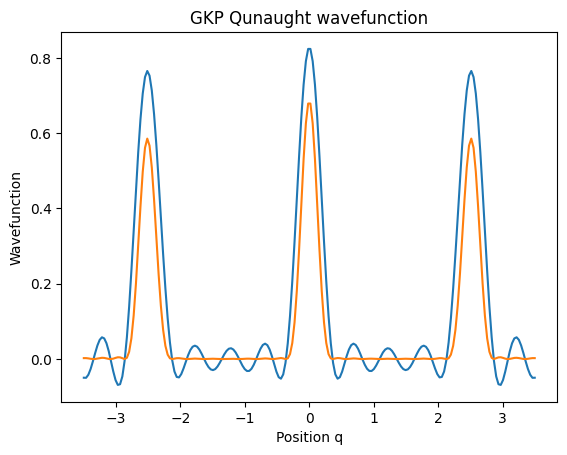

In [59]:
from O2O_funcs import *
# Define the q value
q = np.linspace(-3.5, 3.5, 200)
eps =  0.019
n_max = 70
# Generate the GKP state and coefficients
qunaught, qunaught_coeffs = qunaught_fock(eps, q, n_max, norm = True)
# Calculate the norm
norm = np.linalg.norm(qunaught_coeffs)

# Check if the coefficients are normalized
if np.isclose(norm, 1.0, atol=1e-9):
    print("The coefficients are normalized.")
else:
    print(f"The coefficients are not normalized. Norm = {norm:.9f}")
    
#plot the qunaught wavefunction
plt.plot(q, qunaught)
plt.plot(q, np.abs(qunaught)**2)
plt.title(f'GKP Qunaught wavefunction')
plt.xlabel('Position q')
plt.ylabel('Wavefunction')
plt.show()

In [60]:
prog = sf.Program(1)

# Initialize the state
with prog.context as q:
    Ket(qunaught_coeffs) | q[0]

# Run the program on a bosonic backend
eng = sf.Engine("fock", backend_options={"cutoff_dim": n_max+1})
state = eng.run(prog).state

# Set the scale for phase space
sf.hbar = 1
scale = np.sqrt(sf.hbar * np.pi)

# Define the phase space region for plotting
quad = np.linspace(-3.5, 3.5, 200) * scale

# plot_wigner_function(quad, state)


### GKP-Repetition Code
The GKP repetition code (see [here](https://arxiv.org/abs/1903.12615) for further details) encodes a logical oscillator into two physical oscillators, i.e. one data oscillator and one ancilla oscillator (encoded in the GKP qunaught state). Error correction requires SUM gates (```sf.ops.CXgate```)  and homodyne measurements.


In [ ]:
# Number of samples per variance value
n_shots = 100

input_variances = np.linspace(0.1, 0.5, 5)  # Range of input variances
fidelities_vacuum = []  # To store averaged fidelities with the vacuum state

q = np.linspace(-3.5, 3.5, 200)
eps = 0.019
n_max = 30
_, qunaught_coeffs = qunaught_fock(eps, q, n_max, norm=True)

for var in input_variances:
    fidelity_samples = []  # Temporary storage for fidelities in all shots

    for _ in range(n_shots):
        prog = sf.Program(2)

        with prog.context as q:
            Fock(0) | q[0] #data mode
            Ket(qunaught_coeffs) | q[1] #ancilla mode

            # Encode
            CXgate() | (q[0], q[1])

            # AGN channel
            for mode in range(2):
                Dgate(agn_sample(variance=var), phi=0) | q[mode]  # sigma_q
                Dgate(agn_sample(variance=var), phi=np.pi/2) | q[mode]  # sigma_p

            # Decode
            CXgate().H | (q[0], q[1])

            # Measure X and apply corrections
            CXgate() | (q[0], q[1])
            MeasureX | q[1]
            Dgate(decode_q(q[1].par)) | q[0]

            # Measure P and apply corrections
            CXgate().H | (q[1], q[0])  # inverse sum
            MeasureP | q[1]
            Dgate(decode_p(q[1].par), phi=np.pi/2) | q[0]

        eng = sf.Engine("fock", backend_options={"cutoff_dim": n_max + 1})
        result = eng.run(prog)

        # Compute the fidelity of mode 0 with the vacuum state
        fidelity = result.state.fidelity_vacuum(mode=0)

        # Store result from this shot
        fidelity_samples.append(fidelity)

    # Average fidelities over all shots for this variance value
    fidelities_vacuum.append(np.mean(fidelity_samples))

# Store results for plotting
results = {
    "input_variances": input_variances,
    "fidelities_vacuum": fidelities_vacuum,
}

In [ ]:
fidelities_vacuum_baseline = []  # To store averaged fidelities for physical mode

for var in input_variances:
    fidelity_samples_baseline = []  # Temporary storage for fidelities in all shots

    for _ in range(n_shots):
        prog = sf.Program(1)  

        with prog.context as q:
            # Initialize in the vacuum state
            Fock(0) | q[0]

            # AGN channel
            Dgate(agn_sample(variance=var), phi=0) | q[0]  # sigma_q
            Dgate(agn_sample(variance=var), phi=np.pi/2) | q[0]  # sigma_p

        eng = sf.Engine("fock", backend_options={"cutoff_dim": n_max + 1})
        result = eng.run(prog)

        # Compute the fidelity of the mode with the vacuum state
        fidelity = result.state.fidelity_vacuum(mode=0)

        # Store result from this shot
        fidelity_samples_baseline.append(fidelity)

    # Average fidelities over all shots for this variance value
    fidelities_vacuum_baseline.append(np.mean(fidelity_samples_baseline))

# Store results for plotting
results_baseline = {
    "input_variances": input_variances,
    "fidelities_vacuum_baseline": fidelities_vacuum_baseline,
}

In [64]:
# # Plotting the fidelity vs input variance
# plt.figure(figsize=(10, 6))

# # Plot fidelity with the vacuum state (GKP repetition code)
# plt.plot(
#     results["input_variances"],
#     results["fidelities_vacuum"],
#     marker="o",
#     label="GKP Repetition Code",
# )

# # Plot fidelity with the baseline vacuum state (no encoding/decoding)
# plt.plot(
#     results_baseline["input_variances"],
#     results_baseline["fidelities_vacuum_baseline"],
#     marker="s",
#     linestyle="--",
#     label="Baseline Vacuum State",
# )

# # Customize the plot
# plt.title("Fidelity vs Input Variance: GKP Code vs Baseline Vacuum")
# plt.xlabel("Input Variance")
# plt.ylabel("Fidelity")
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.show()
